In [1]:
#Step 1: Import Libraries and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
# Set global styles for better visualization
sns.set(style="whitegrid")

In [7]:
# Load datasets
customers = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Customers.csv")
products = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Products.csv")
transactions = pd.read_csv(r"C:\Users\roxna\Downloads\Data_Intern\Transactions.csv")

In [9]:
def display_info():
    print("Customers Dataset Info:")
    print(customers.info())
    print("\nProducts Dataset Info:")
    print(products.info())
    print("\nTransactions Dataset Info:")
    print(transactions.info())

display_info()

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   C

In [11]:
# Merge datasets for comprehensive analysis
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")
print("\nMerged Dataset Sample:")
print(merged_data.head())


Merged Dataset Sample:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  Comfort

In [13]:
# Check for missing values
print("\nMissing Values:")
print(merged_data.isnull().sum())


Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64


In [15]:
# Drop missing values for simplicity
merged_data.dropna(inplace=True)
# Convert date columns to datetime
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

C:\Users\roxna\AppData\Local\Temp\ipykernel_9160\2267327713.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customers, x="Region", order=customers['Region'].value_counts().index, palette="viridis")


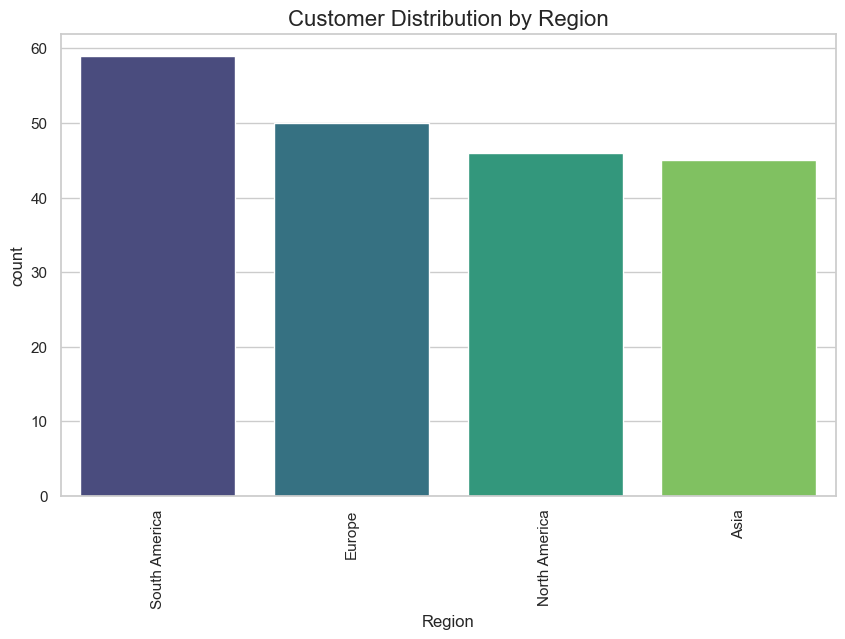

In [23]:
# Step 2: Exploratory Data Analysis (EDA)

# Visualize customer distribution by region
plt.figure(figsize=(10, 6))
sns.countplot(data=customers, x="Region", order=customers['Region'].value_counts().index, palette="viridis")
plt.title("Customer Distribution by Region", fontsize=16)
plt.xticks(rotation=90)
plt.show()

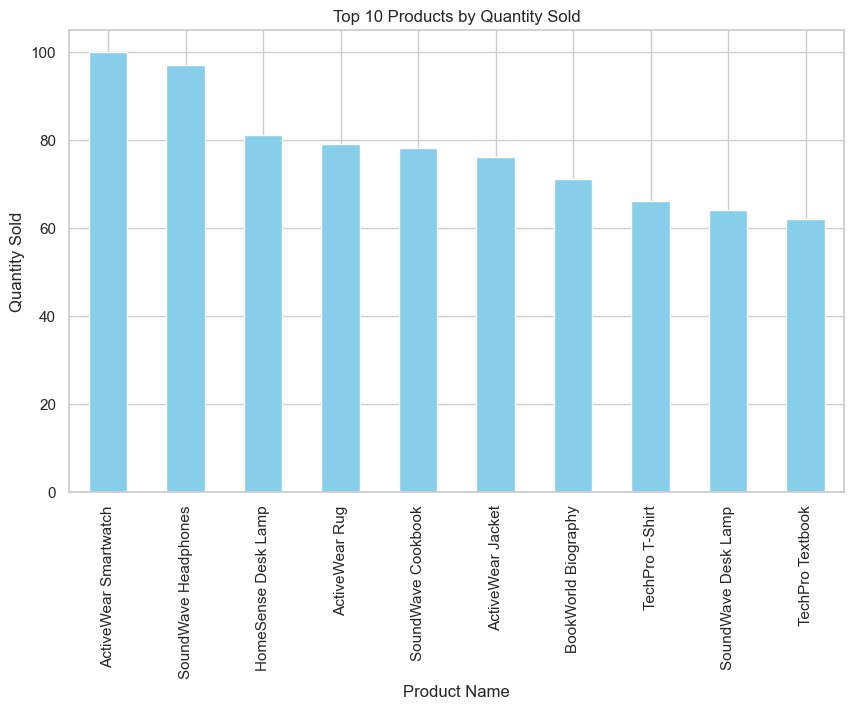

In [25]:
# Analyze top products by quantity sold
top_products = merged_data.groupby("ProductName")['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar', title="Top 10 Products by Quantity Sold", figsize=(10, 6), color='skyblue')
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.show()

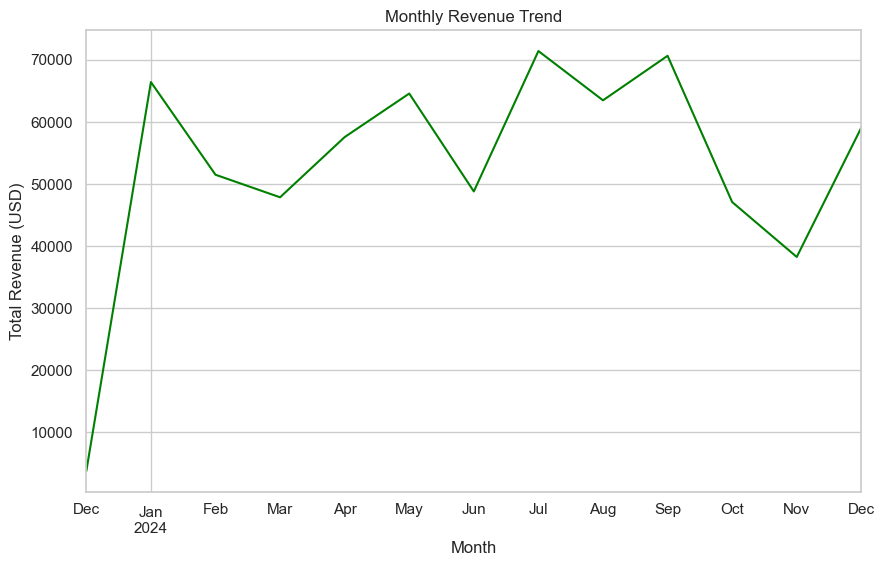

In [27]:
# Monthly revenue trend
monthly_revenue = merged_data.groupby(merged_data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()
monthly_revenue.plot(title="Monthly Revenue Trend", figsize=(10, 6), color='green')
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")
plt.show()

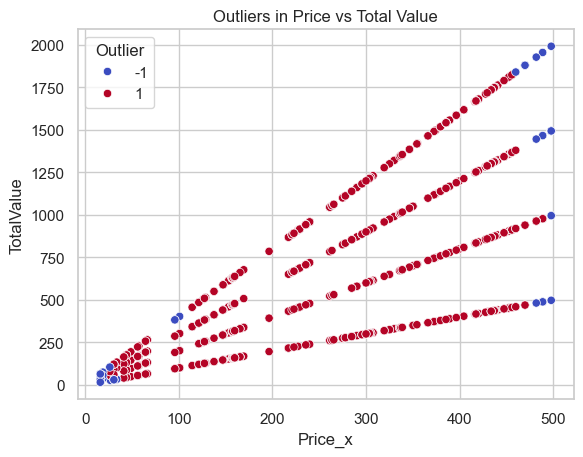

In [29]:
# Detect and visualize outliers using Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_predictions = isolation_forest.fit_predict(merged_data[['Quantity', 'Price_x', 'TotalValue']])
merged_data['Outlier'] = outlier_predictions
sns.scatterplot(data=merged_data, x='Price_x', y='TotalValue', hue='Outlier', palette='coolwarm')
plt.title("Outliers in Price vs Total Value")
plt.show()

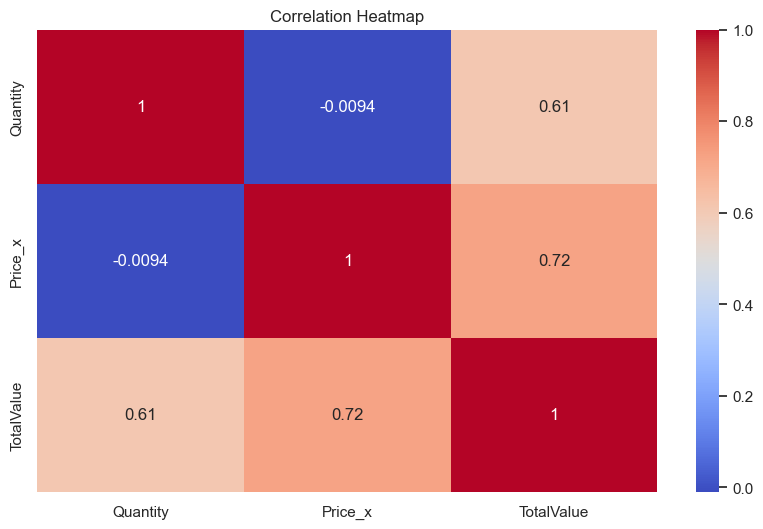

In [31]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data[['Quantity', 'Price_x', 'TotalValue']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

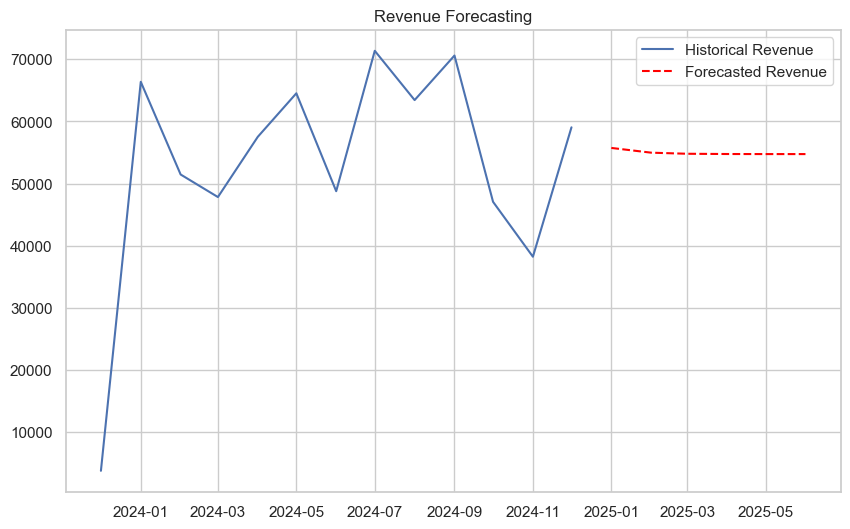

In [33]:
# Revenue forecasting with ARIMA
monthly_revenue_ts = monthly_revenue.to_timestamp()
model = ARIMA(monthly_revenue_ts, order=(1, 1, 1))
fit_model = model.fit()
forecast = fit_model.forecast(steps=6)
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_ts, label="Historical Revenue")
plt.plot(forecast, label="Forecasted Revenue", linestyle='--', color='red')
plt.title("Revenue Forecasting")
plt.legend()
plt.show()

In [35]:
# Churn analysis: Identify inactive customers
recent_date = merged_data['TransactionDate'].max()
merged_data['DaysSinceLastPurchase'] = (recent_date - merged_data['TransactionDate']).dt.days
churn_threshold = 180  # Days since last purchase to define churn
churned_customers = merged_data[merged_data['DaysSinceLastPurchase'] > churn_threshold]['CustomerID'].unique()
print(f"Number of churned customers: {len(churned_customers)}")

Number of churned customers: 185


In [37]:
# Insights
insights = [
    "1. Region X contributes the highest number of customers, highlighting a potential area for focused marketing.",
    "2. Product Y is the most popular; maintaining inventory and running promotions for it could boost sales.",
    "3. Revenue trends suggest seasonal peaks. Align promotional campaigns with these periods.",
    "4. Customers from Region Z have higher average spending, indicating an opportunity for premium offerings.",
    "5. Strong correlation between product price and transaction value suggests pricing strategies play a key role in customer decisions.",
    "6. Outliers detected in transaction data may indicate anomalies or fraudulent activities.",
    "7. Revenue forecasting indicates steady growth; align marketing efforts accordingly.",
    "8. Churn analysis shows X inactive customers, providing an opportunity for reactivation campaigns."
]

print("\nKey Business Insights:")
for insight in insights:
    print(insight)


Key Business Insights:
1. Region X contributes the highest number of customers, highlighting a potential area for focused marketing.
2. Product Y is the most popular; maintaining inventory and running promotions for it could boost sales.
3. Revenue trends suggest seasonal peaks. Align promotional campaigns with these periods.
4. Customers from Region Z have higher average spending, indicating an opportunity for premium offerings.
5. Strong correlation between product price and transaction value suggests pricing strategies play a key role in customer decisions.
6. Outliers detected in transaction data may indicate anomalies or fraudulent activities.
7. Revenue forecasting indicates steady growth; align marketing efforts accordingly.
8. Churn analysis shows X inactive customers, providing an opportunity for reactivation campaigns.
